In [1]:
import sys, h5py, pdb,time, glob, os
from importlib import reload
import pylab as pl, numpy as np
from numpy import log10 as log
from astropy import units as un, constants as cons
import scipy, scipy.stats
from matplotlib import ticker, patches
sys.path.append('../../pysrc')

In [3]:
import FIRE_files as ff
from FIRE_files import cosmo, u
from projectPlotBasics import *
import first_pass as l
cmap = pl.get_cmap('viridis')

palettable colormaps are not installed
don't have phil's colormaps


In [4]:
CF_path = '../../../cooling_flow/pysrc'
sys.path.append(CF_path)
import cooling_flow as CF, HaloPotential as Halo
%matplotlib inline

In [24]:
simname = 'highres'
vc = 200. *un.km/un.s
Rcirc = 10.*un.kpc
simdir = '/projects/b1026/jonathan/KY_sims/sim_outputs/%s/output/'%simname

In [25]:
sim = l.KY_sim(simname,simdir,200*un.kpc,origin=np.zeros(3),Rcirc = Rcirc,snapshot_dt_Myr=10,pr=False,
              analyticGravity= Halo.PowerLaw(m=0.,vc_Rvir=vc,Rvir=200*un.kpc))
sim.z = 0 #for cooling function
print(sim.galaxyname, sim.Nsnapshots())

highres 93


In [26]:
snapshot = sim.getSnapshot(92)

In [27]:
inds = (snapshot.Ts()<4e5) & (snapshot.Ts()>2e5) & (Rs>8) & (Rs<10)

In [28]:
nHs = snapshot.nHs()
tcools = snapshot.t_cool()

In [29]:
vs = snapshot.vs()
coords = snapshot.coords()
xs,ys,zs = coords[:,0],coords[:,1],coords[:,2]
rs    = (xs**2+ys**2+zs**2)**0.5
Rs    = (xs**2+ys**2)**0.5
phis  = np.arctan2(ys,xs)
thetas = np.arccos(zs/rs)

In [30]:
js = np.array([coords[:,1] * vs[:,2] - coords[:,2] * vs[:,1],
               coords[:,2] * vs[:,0] - coords[:,0] * vs[:,2],
               coords[:,0] * vs[:,1] - coords[:,1] * vs[:,0]])
js=js.T
jzs = js[:,2]

In [31]:
vphis = jzs/Rs
Omegas = jzs/Rs**2 * un.km/un.s/un.kpc
vzs = vs[:,2]
vRs = (vs[:,0]*xs/rs + vs[:,1]*ys/rs)
vrs = (vs[:,0]*xs/rs + vs[:,1]*ys/rs + vs[:,2]*zs/rs)
# cos𝜃cos𝜙𝐱+cos𝜃sin𝜙𝐲−sin𝜃𝐳)𝜃
vthetas = vs[:,0]*np.cos(thetas)*np.cos(phis) + vs[:,1]*np.cos(thetas)*np.sin(phis) - vs[:,2]*np.sin(thetas)

In [32]:
import scipy, scipy.stats

$v_\theta$ mean=16.973, std=30.950
$v_r$ mean=-10.770, std=26.731
$v_\phi$ mean=213.642, std=24.410
$v_R$ mean=-10.196, std=26.616
$v_{|z|}$ mean=-17.283, std=31.048


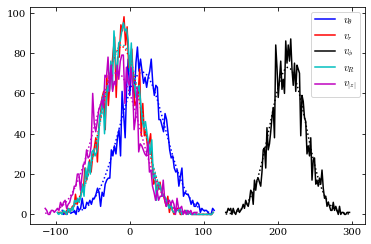

In [129]:
above_plane = (-1)**(zs<0.3)
vspherical = [(vthetas*above_plane)[inds],vrs[inds],vphis[inds],vRs[inds],(above_plane*vzs)[inds]]
for iv,v in enumerate(vspherical):
    c = 'brkcm'[iv]
    label = (r'$v_\theta$',r'$v_r$',r'$v_\phi$',r'$v_R$',r'$v_{|z|}$')[iv]
    a,b=pl.histogram(v,bins=100)
    mean,std = np.mean(v),np.std(v); print(label, 'mean=%.3f, std=%.3f'%(mean,std))
    bb = (b[1:]+b[:-1])/2; db = bb[1]-bb[0]
    pl.plot(bb,a,c=c,label=label)
    pl.plot(bb,scipy.stats.norm.pdf(bb,loc=mean,scale=std)*a.sum()*db,c=c,ls=':')
    pl.legend()

In [46]:
ls =((1e4*un.Msun/(4*np.pi/3*cons.m_p*nHs*un.cm**-3/0.7))**(1/3)).to('kpc')

In [54]:
(ls.to('cm')*nHs*un.cm**-3*ls**2/(2*un.kpc*2*np.pi*9*un.kpc))[inds].sum() * 5e-4*0.2/3

<Quantity 1.62538128e+14 1 / cm2>

In [61]:
np.median(ls[inds])

<Quantity 0.10943618 kpc>

In [60]:
np.median(nHs[inds])*1e-4/3

1.7197967817385993e-06

In [65]:
np.median(tcools[inds])

1.9614762444724372

In [69]:
(10*un.kpc / (200*un.km/un.s)).to('Myr')

<Quantity 48.88961108 Myr>

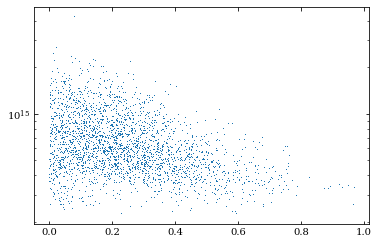

In [124]:
pl.semilogy(np.abs(zs[inds]-0.3),(ls*nHs*un.kpc.to('cm')*1e-4/3)[inds],',')

In [33]:
xs,ys,zs = [snapshot.coords()[:,i] for i in range(3)]
phis = np.arctan2(ys,xs)
Rs = (xs**2+ys**2)**0.5
rs = (Rs**2+zs**2)**0.5
thetas = np.arccos(zs/rs)

In [8]:
bins_Rs = np.arange(0.,35.1,0.2);  midbins_Rs = (bins_Rs[1:]+bins_Rs[:-1])/2
bins_zs = np.arange(-20,20.1,0.2); midbins_zs = (bins_zs[1:]+bins_zs[:-1])/2
Ts_cyl,_,_,bin_inds = scipy.stats.binned_statistic_2d(Rs,zs,log(snapshot.Ts()),statistic='mean',bins=(bins_Rs,bins_zs))  

In [9]:
# bins_Rs_quiver = np.arange(0.,20.5,1);  midbins_Rs_quiver = (bins_Rs_quiver[1:]+bins_Rs_quiver[:-1])/2
# bins_zs_quiver = np.arange(-10,10.5,1); midbins_zs_quiver = (bins_zs_quiver[1:]+bins_zs_quiver[:-1])/2
# _vRs = snapshot.vs()[:,0]*np.cos(phis) + snapshot.vs()[:,1]*np.sin(phis)
# vRs,_,_,bin_inds = scipy.stats.binned_statistic_2d(Rs,zs,_vRs,              statistic='mean',bins=(bins_Rs_quiver,bins_zs_quiver))  
# vzs,_,_,bin_inds = scipy.stats.binned_statistic_2d(Rs,zs,snapshot.vs()[:,2],statistic='mean',bins=(bins_Rs_quiver,bins_zs_quiver))  

In [10]:
bins_xs = np.arange(-35,35.025,0.05); midbins_xs = (bins_xs[1:]+bins_xs[:-1])/2
bins_ys = np.arange(-35,35.025,0.05); midbins_ys = (bins_ys[1:]+bins_ys[:-1])/2
inds = np.abs(zs)<10
# inds = (zs>10) & (zs<15)
Ts_faceon,_,_,bin_inds = scipy.stats.binned_statistic_2d(xs[inds],ys[inds],log(snapshot.Ts()[inds]),statistic='mean',bins=(bins_xs,bins_ys))  

In [11]:
# bins_xs_quiver = np.arange(-30,31,2.5); midbins_xs_quiver = (bins_xs_quiver[1:]+bins_xs_quiver[:-1])/2
# bins_ys_quiver = np.arange(-30,31,2.5); midbins_ys_quiver = (bins_ys_quiver[1:]+bins_ys_quiver[:-1])/2
# vxs,_,_,bin_inds = scipy.stats.binned_statistic_2d(xs[inds],ys[inds],snapshot.vs()[:,0][inds],statistic='mean',bins=(bins_xs_quiver,bins_ys_quiver))  
# vys,_,_,bin_inds = scipy.stats.binned_statistic_2d(xs[inds],ys[inds],snapshot.vs()[:,1][inds],statistic='mean',bins=(bins_xs_quiver,bins_ys_quiver))  

In [12]:
npz_fn = simdir+'../../tracking/output/particle_tracks.npz'
f = np.load(npz_fn)
coords_tracks,vs_tracks,Ts_tracks,nHs_tracks,tcools_tracks = f['coords'],f['vs'],f['Ts'],f['nHs'],f['tcools']
xs_tracks,ys_tracks,zs_tracks = [coords_tracks[:,:,i] for i in range(3)]
rs_tracks    = (xs_tracks**2+ys_tracks**2+zs_tracks**2)**0.5
Rs_tracks    = (xs_tracks**2+ys_tracks**2)**0.5
thetas_tracks = np.arccos(zs_tracks/rs_tracks)
phis_tracks  = np.arctan2(ys_tracks,xs_tracks)

In [17]:
l = 13
theta_midbins = np.arccos(np.linspace(-1.,1,l)); print(theta_midbins/np.pi)
phi_midbins = np.linspace(-1.,1,l)*np.pi
dtheta = 0.025*np.pi
theta_inds = np.zeros((len(theta_midbins),thetas_tracks.shape[1]))
phi_inds   = np.zeros((len(theta_midbins),thetas_tracks.shape[1]))
for itheta,theta_midbin in enumerate(theta_midbins):
    theta_infty = np.median(thetas_tracks[-10:,:],axis=0)
    phi_infty = phis_tracks[-1,:]
    if itheta<l-1: print(((theta_infty>theta_midbins[itheta+1]) & (theta_infty<theta_midbins[itheta])).sum(),end=',')
    theta_inds[itheta,:] = (theta_infty<theta_midbin       +dtheta) & (theta_infty>theta_midbin       -dtheta)
    phi_inds[itheta,:]   = (phi_infty  <phi_midbins[itheta]+dtheta) & (phi_infty  >phi_midbins[itheta]-dtheta)
theta_inds = theta_inds.astype('bool')
phi_inds = phi_inds.astype('bool')
print(); print(theta_inds.sum(axis=1)); print(phi_inds.sum(axis=1))
tracks = [None]*len(theta_midbins); xytracks = [None]*len(theta_midbins); 
for i,ind in enumerate(theta_midbins):
    tracks[i]   = [np.nanmean(vals[:,theta_inds[i]],axis=1) for vals in (Rs_tracks,zs_tracks)]
    xytracks[i] = [np.nanmean(vals[:,theta_inds[6] & phi_inds[i]],axis=1) for vals in (xs_tracks,ys_tracks)]

[1.         0.8135705  0.73227953 0.66666667 0.60817345 0.55330038
 0.5        0.44669962 0.39182655 0.33333333 0.26772047 0.1864295
 0.        ]
3149,3385,3594,3699,3788,3892,3949,3847,3772,3538,3403,3227,
[  58 1688 2446 3011 3336 3564 3682 3639 3392 2954 2453 1729   63]
[ 541 1071 1025 1079 1071 1076 1086 1110 1117 1082 1064 1058  537]


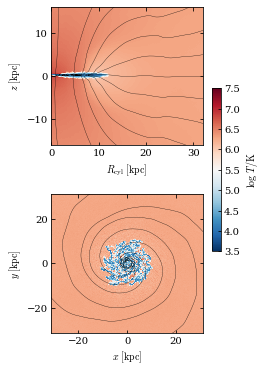

In [18]:
Tmin,Tmax = 3.5,7.5
pl.figure(figsize=(fig_width_half,6)); pl.subplots_adjust(hspace=0.35)
ax1 = pl.subplot(211)
mesh = pl.pcolormesh(midbins_Rs,midbins_zs,Ts_cyl.T,cmap='RdBu_r',zorder=-100,vmin=Tmin,vmax=Tmax) 
# pl.quiver(midbins_Rs_quiver,midbins_zs_quiver,vRs.T,vzs.T)
for i,ind in enumerate(theta_midbins):
    pl.plot(tracks[i][0],tracks[i][1],c='k',lw=0.3)
pl.ylim(-16,16); pl.xlim(0,32)
pl.xlabel(r'$R_{\rm cyl}\ [{\rm kpc}]$')
pl.ylabel(r'$z\ [{\rm kpc}]$')
ax2 = pl.subplot(212)
mesh = pl.pcolormesh(midbins_xs,midbins_ys,Ts_faceon.T,cmap='RdBu_r',zorder=-100,vmin=Tmin,vmax=Tmax) 
# pl.quiver(midbins_xs_quiver,midbins_ys_quiver,vxs.T,vys.T)
[pl.plot(xytracks[i][0],xytracks[i][1],c='k',lw=0.3) for i in range(0,len(xytracks)-1,3)]
pl.xlabel(r'$x\ [{\rm kpc}]$')
pl.ylabel(r'$y\ [{\rm kpc}]$')
pl.ylim(-31,31); pl.xlim(-31,31)
cb = pl.colorbar(mesh,ax=(ax1,ax2),orientation='vertical',label=r'$\log\ T/{\rm K}$',shrink=0.5)
pl.savefig('snapshot_map.png',bbox_inches='tight',dpi=300)

# hot gas profile plot

In [34]:
r=30
theta_bins = np.linspace(0,np.pi,100); mid_bins = (theta_bins[1:]+theta_bins[:-1])/2
inds = (rs>r-1) & (rs<r+1)
hist_Ts,_,bin_inds     = scipy.stats.binned_statistic(thetas[inds],snapshot.Ts()[inds],        statistic='mean',bins=theta_bins)  
hist_ns,_,bin_inds     = scipy.stats.binned_statistic(thetas[inds],snapshot.nHs()[inds],        statistic='mean',bins=theta_bins)  
hist_Lxs,_,bin_inds    = scipy.stats.binned_statistic(thetas[inds],snapshot.rad_per_unit_volume()[inds],statistic='mean',bins=theta_bins)  
hist_Omegas,_,bin_inds = scipy.stats.binned_statistic(thetas[inds],snapshot.v_phi()[inds]/Rs[inds],statistic='median',bins=theta_bins)  

In [35]:
r2=15
inds2 = (rs>r2-1) & (rs<r2+1)
hist_Ts2,_,bin_inds     = scipy.stats.binned_statistic(thetas[inds2],snapshot.Ts()[inds2],        statistic='mean',bins=theta_bins)  
hist_ns2,_,bin_inds     = scipy.stats.binned_statistic(thetas[inds2],snapshot.nHs()[inds2],        statistic='mean',bins=theta_bins)  
hist_Lxs2,_,bin_inds    = scipy.stats.binned_statistic(thetas[inds2],snapshot.rad_per_unit_volume()[inds2],statistic='mean',bins=theta_bins)  
hist_Omegas2,_,bin_inds = scipy.stats.binned_statistic(thetas[inds2],snapshot.v_phi()[inds2]/Rs[inds2],statistic='median',bins=theta_bins)  

In [36]:
print(hist_Lxs2.max(), hist_Lxs2.min())


1.7313060441840774e-28 1.6631624786061883e-29


In [50]:
print(snapshot.mus()[inds].min(),snapshot.mus()[inds].max(),ff.mu)
print(snapshot.ne2nHs()[inds].min(),snapshot.ne2nHs()[inds].max(),ff.ne2nH)

0.59344363 0.59344405 0.62
1.1683878 1.1683893 1.2


In [37]:
vc = 206
Mdot = 6.25
Ts_radial = lambda r: (vc/200)**2*2e6
Lambda_rad= lambda r: ff.LambdaFunc(0)(Ts_radial(0),0.1,0.1)
ns_radial = lambda r: 0.8e-3*(r/10)**-1.5*vc/200*Mdot**0.5*(Lambda_rad(0)/1e-22)**-0.5
Lx_radial = lambda r: ns_radial(r)**2*Lambda_rad(r)
Omega_rad = lambda r: 0.

Ts_anal     = lambda r,theta: Ts_radial(r) * (1-(r/10)**-2*(2*np.sin(theta)-5/6))
ns_anal     = lambda r,theta: ns_radial(r) * (1+(r/10)**-2*(11/4*np.sin(theta)-35/24))
Lambda_anal = lambda r,theta: ff.LambdaFunc(0)(Ts_anal(r,theta),ns_anal(r,theta),0.1)
Lx_anal     = lambda r,theta: ns_anal(r,theta)**2*Lambda_anal(r,theta)
Omegas_anal = lambda r,theta: np.ones(theta.shape) * vc * 10 / r**2 * (un.km/un.s/un.kpc).to('Gyr**-1')

In [ ]:
fig = pl.figure(figsize=(fig_width_full,5)); pl.subplots_adjust(wspace=0.325)
for i in range(4):
    ax = pl.subplot(2,2,i+1)
    norm = (1,1e6,1e-3,1e-29)[i]
    ys = (hist_Omegas, hist_Ts, hist_ns, hist_Lxs)[i]
    ys2 = (hist_Omegas2, hist_Ts2, hist_ns2, hist_Lxs2)[i]
    order1 = (Omegas_anal, Ts_anal,ns_anal,Lx_anal)[i]
    order0 = (Omega_rad,Ts_radial,ns_radial,Lx_radial)[i]
    label = (r'$\Omega\ [{\rm rad}\ {\rm Gyr}^{-1}]$',r'$T\ [10^6\ {\rm K}]$', r'$n_{\rm H}\ [10^{-3}\ {\rm cm}^{-3}]$',r'$L_X\ [10^{-28}\ {\rm erg}\ {\rm cm}^{-3}\ {\rm s}^{-1}]$')[i]
    pl.plot(mid_bins[1:-1],ys[1:-1]/norm, c='b',ls='-',label=r'simulation, $r=%d\ {\rm kpc}$'%r)
    pl.plot(mid_bins,order1(r,mid_bins)/norm,c='b',ls='--',label=r'analytic, slow rotating, $r=%d\ {\rm kpc}$'%r)
    pl.axhline(order0(r)/norm,c='b',ls=':',label=r'analytic, non-rotating, $r=%d\ {\rm kpc}$'%r)
    pl.plot(mid_bins[1:-1],ys2[1:-1]/norm,c='k',ls='-',label=r'simulation, $r=%d\,{\rm kpc}$'%r2)
    pl.plot(mid_bins,order1(r2,mid_bins)/norm,c='k',ls='--',label=r'analytic, slow rotating, $r=%d\ {\rm kpc}$'%r2)
    pl.axhline(order0(r2)/norm,c='k',ls=':',label=r'analytic, non-rotating, $r=%d\ {\rm kpc}$'%r2)
    if ax.is_last_row(): pl.xlabel(r'$\theta$')
    pl.ylabel(label)    
    ax.xaxis.set_major_locator(ticker.FixedLocator(np.linspace(0,1,5)*np.pi))
    ax.xaxis.set_major_formatter(ticker.FixedFormatter([r'$0$',r'$\pi/4$',r'$\pi/2$',r'$3\pi/4$',r'$\pi$']))
#     yls = ((-0.5,5),(1.6,2.6),(0.6,1.6),(0,3))[i]; pl.ylim(*yls)    
pl.legend(loc='upper center', bbox_to_anchor=(-0.25, -0.3),ncol=2)
pl.savefig('comparison_to_analytic.pdf',bbox_inches='tight')

# verify cooling calculation is similar to that in FIRE

In [100]:
import os, glob
from scipy import interpolate
tables_dir = os.getenv("HOME")+'/github_repositories/gizmo_analysis/CoolingTables/'

def LambdaFile(z):
    fns = np.array(glob.glob(tables_dir+'z_?.???.hdf5'))
    zs = np.array([float(fn[-10:-5]) for fn in fns])
    fn = fns[zs.argsort()][u.searchsortedclosest(sorted(zs), z)]
    print(fn)
    f=h5py.File(fn,'r')
    return f

In [102]:
Zsun = [0.0129,0.2806,2.07e-3,8.36e-4,5.49e-3,1.41e-3,5.91e-4,6.83e-4,4.09e-4,6.44e-5,1.1e-3]

In [103]:
LAMBDA1 = ff.LambdaFunc(0)
print(LAMBDA1(2e6,0.1,0.1))
f = LambdaFile(0)
a = snapshot.dic['PartType0','Metallicity'][inds][0]
FIRE_inds = ['Z','Helium','Carbon','Nitrogen','Oxygen','Neon','Magnesium','Silicon','Sulphur','Calcium','Iron']
iHe = u.searchsortedclosest(f['Metal_free']['Helium_mass_fraction_bins'][:],a[1])
H_He_Cooling  = f['Metal_free']['Net_Cooling'][iHe,...]
Tbins         = f['Metal_free']['Temperature_bins'][...]
nHbins        = f['Metal_free']['Hydrogen_density_bins'][...]
Metal_Cooling = np.sum([f[FIRE_inds[i]]['Net_Cooling'][...]*a[i]/Zsun[i] for i in range(2,11)],axis=0)
f_H_He = interpolate.RegularGridInterpolator((log(Tbins), log(nHbins)),
                                                    H_He_Cooling,
                                                    bounds_error=False, fill_value=None)
f_Z    = interpolate.RegularGridInterpolator((log(Tbins), log(nHbins)),
                                                    Metal_Cooling,
                                                    bounds_error=False, fill_value=None)
f2 = lambda T,nH,f_H_He=f_H_He,f_Z=f_Z: (
        f_H_He((log(T), log(nH))) + f_Z((log(T), log(nH))))
f2(2e6,0.001)


1.4038108602647772e-23
/home/ysz5546/github_repositories/gizmo_analysis/CoolingTables/z_0.000.hdf5


1.3182569998698887e-23

In [173]:
bins_Rs = np.arange(-0.5,12.5,0.05); midbins_Rs = (bins_Rs[1:]+bins_Rs[:-1])/2
bins_zs = np.arange(-2.1,2.11,0.05); midbins_zs = (bins_zs[1:]+bins_zs[:-1])/2
hist_Ts,a,b,bin_inds = scipy.stats.binned_statistic_2d(Rs,zs,log(snapshot.Ts()),statistic='mean',bins=(bins_Rs,bins_zs))  
hist_vzs,a,b,bin_inds = scipy.stats.binned_statistic_2d(Rs,zs,np.abs(snapshot.vs()[:,2]),statistic='mean',bins=(bins_Rs,bins_zs))  

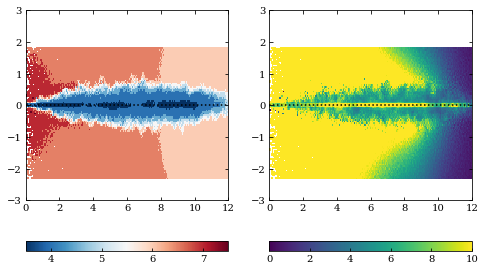

In [180]:
pl.figure(figsize=(8,5))
for iPanel in range(2):
    ax = pl.subplot(1,2,iPanel+1)
    if iPanel==0:
        mesh = pl.pcolormesh(midbins_Rs,midbins_zs-0.25,0.5*((hist_Ts.T+0.25)//0.5),cmap='RdBu_r',zorder=-100) 
    if iPanel==1:
        mesh = pl.pcolormesh(midbins_Rs,midbins_zs-0.25,(hist_vzs / (200*30*np.abs(midbins_zs-0.25))**0.5).T,
                             cmap='viridis',zorder=-100,vmax=10,vmin=0) 
    pl.ylim(-3,3); pl.xlim(0,12)
    cb = pl.colorbar(orientation='horizontal')
#     for i,ind in enumerate(theta_midbins):
#         pl.plot(tracks[i][0],tracks[i][1],c='k')
    pl.axhline(0,c='k',ls=':')

In [60]:
(10**3.5/2e6)**0.5 * 10

0.39763536438352537

In [151]:
bins_Rs = np.arange(-0.5,12.5,0.05); midbins_Rs = (bins_Rs[1:]+bins_Rs[:-1])/2
bins_zs = np.arange(0,2.11,0.05); midbins_zs = (bins_zs[1:]+bins_zs[:-1])/2
hist_masses,a,b,bin_inds = scipy.stats.binned_statistic_2d(
    np.concatenate([(snapshot.coords(j)[:,:2]**2).sum(axis=1)**0.5 for j in range(6) if j!=1]),
    np.concatenate([np.abs(snapshot.coords(j)[:,2]-0.25) for j in range(6) if j!=1]),
    np.concatenate([snapshot.masses(j) for j in range(6) if j!=1]),
    statistic='sum',bins=(bins_Rs,bins_zs))  

In [152]:
hist_masses.shape,  midbins_zs.shape, midbins_Rs.shape

((259, 42), (42,), (259,))

In [153]:
midbins_Rs_grid,midbins_zs_grid = np.meshgrid(midbins_Rs,midbins_zs)
g_isothermal = (200*un.km/un.s)**2 / (midbins_Rs_grid*un.kpc) * midbins_zs_grid / midbins_Rs_grid

In [154]:
gs = (2*np.pi*cons.G * hist_masses.sum(cumsum(axis=1).T*un.Msun / (0.05*un.kpc)**2).to('km**2*s**-2/kpc')


In [172]:
# gz ~ vc^2
((2*np.pi*cons.G*1e10*un.Msun / (np.pi*(10*un.kpc)**2) * 1*un.kpc)**0.5).to('km/s')

<Quantity 29.3288843 km / s>

In [166]:
np.searchsorted(midbins_Rs,10)

210

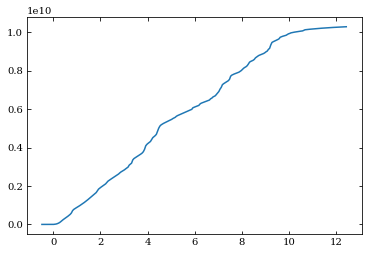

In [169]:
pl.plot(midbins_Rs,hist_masses.cumsum(axis=1).cumsum(axis=0)[:,-1])

In [155]:
#point source: 4pi r^2 g = 4 pi GM 
#plane parallel 2Ag = 4 pi G sigma A -> g = 2 pi G sigma

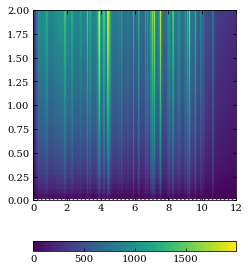

In [157]:
pl.figure(figsize=(8,5))
for iPanel in range(1,2):
    ax = pl.subplot(1,2,iPanel+1)
    if iPanel==0:
        mesh = pl.pcolormesh(midbins_Rs,midbins_zs-0.25,0.5*((hist_Ts.T+0.25)//0.5),cmap='RdBu_r',zorder=-100) 
    if iPanel==1:
        mesh = pl.pcolormesh(midbins_Rs,midbins_zs,(gs*midbins_zs_grid)**0.5,
                             cmap='viridis',zorder=-100) 
    pl.ylim(0,2); pl.xlim(0,12)
    cb = pl.colorbar(orientation='horizontal')
#     for i,ind in enumerate(theta_midbins):
#         pl.plot(tracks[i][0],tracks[i][1],c='k')
    pl.axhline(0,c='k',ls=':')

In [103]:
snapshot.dic[('PartType0','Masses')][:100]

array([0.01771542, 0.01771542, 0.01771542, 0.01771542, 0.01771542,
       0.01771542, 0.01771542, 0.01771542, 0.01771542, 0.01771542,
       0.01771542, 0.01771542, 0.01771542, 0.01771542, 0.01771542,
       0.01771542, 0.01771542, 0.01771542, 0.01771542, 0.01771542,
       0.01771542, 0.01771542, 0.01771542, 0.01771542, 0.01771542,
       0.01771542, 0.01771542, 0.01771542, 0.01771542, 0.01771542,
       0.01771542, 0.01771542, 0.01771542, 0.01771542, 0.01771542,
       0.01771542, 0.01771542, 0.01771542, 0.01771542, 0.01771542,
       0.01771542, 0.01771542, 0.01771542, 0.01771542, 0.00590503,
       0.01771542, 0.01771542, 0.01771542, 0.01771542, 0.01771542,
       0.01771542, 0.01771542, 0.00590503, 0.00590503, 0.00590503,
       0.00590503, 0.00590503, 0.00590503, 0.00590503, 0.00590503,
       0.01771542, 0.00590503, 0.01771542, 0.01771542, 0.01771542,
       0.00590503, 0.00590503, 0.01771542, 0.01771542, 0.01771542,
       0.00590503, 0.00590503, 0.00590503, 0.00590503, 0.00590

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([-100,  -99,  -98,  -97,  -96,  -95,  -94,  -93,  -92,  -91,  -90,
         -89,  -88,  -87,  -86, 

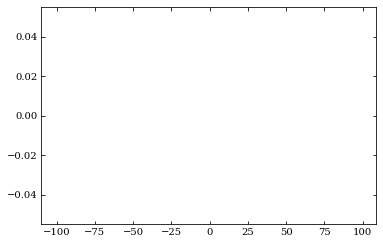

In [92]:
pl.hist(log(snapshot.masses()),bins=np.arange(-100,100))

In [77]:
a=snapshot.dic[('PartType0','Potential')]

KeyError: "Unable to open object (object 'Potential' doesn't exist)"